<a href="https://colab.research.google.com/github/alethat/MachineLearningTasks/blob/main/TaskWeek4/TaskWeek4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Aletha Tanisha

NPM: 2106722770

# **Import Libraries**

In [1]:
# !pip install d2l
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l
from torch.nn import functional as F
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
import time
import numpy as np
import torchvision
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary
import psutil
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

# **Deep Convolutional Neural Networks (AlexNet)**

## **Capacity Control and Preprocessing**

In [ ]:
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
AlexNet().layer_summary((1, 1, 224, 224))

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## **Training**

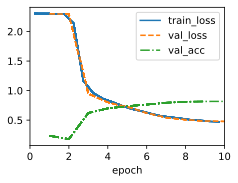

In [ ]:
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

## **Exercises**

1. Following up on the discussion above, analyze the computational properties of AlexNet.
    1. Compute the memory footprint for convolutions and fully connected layers, respectively. Which one dominates?
    1. Calculate the computational cost for the convolutions and the fully connected layers.
    1. How does the memory (read and write bandwidth, latency, size) affect computation? Is there any difference in its effects for training and inference?
1. You are a chip designer and need to trade off computation and memory bandwidth. For example, a faster chip requires more power and possibly a larger chip area. More memory bandwidth requires more pins and control logic, thus also more area. How do you optimize?
1. Why do engineers no longer report performance benchmarks on AlexNet?
1. Try increasing the number of epochs when training AlexNet. Compared with LeNet, how do the results differ? Why?
1. AlexNet may be too complex for the Fashion-MNIST dataset, in particular due to the low resolution of the initial images.
    1. Try simplifying the model to make the training faster, while ensuring that the accuracy does not drop significantly.
    1. Design a better model that works directly on 28x28 images.
1. Modify the batch size, and observe the changes in throughput (images/s), accuracy, and GPU memory.
1. Apply dropout and ReLU to LeNet-5. Does it improve? Can you improve things further by preprocessing to take advantage of the invariances inherent in the images?
1. Can you make AlexNet overfit? Which feature do you need to remove or change to break training?


## **Exercises Solution**

1.1

In [ ]:
# Convolutional layer parameters
num_params_conv = 96 * 3 * 11 * 11 + 256 * 96 * 5 * 5 + 384 * 256 * 3 * 3 + 384 * 384 * 3 * 3 + 256 * 384 * 3 * 3
print(f"Number of parameters for convolutional layers: {num_params_conv}")

# Fully connected layer parameters
num_params_fc = 9216 * 4096 + 4096 * 4096 + 4096 * 10
print(f"Number of parameters for fully connected layers: {num_params_fc}")

# Compute memory footprint for convolutional layers
memory_footprint_conv = num_params_conv * np.float32(0).nbytes
print(f"Memory footprint for convolutional layers: {memory_footprint_conv} bytes")

# Compute memory footprint for fully connected layers
memory_footprint_fc = num_params_fc * np.float32(0).nbytes
print(f"Memory footprint for fully connected layers: {memory_footprint_fc} bytes")

Number of parameters for convolutional layers: 3745824
Number of parameters for fully connected layers: 54566912
Memory footprint for convolutional layers: 14983296 bytes
Memory footprint for fully connected layers: 218267648 bytes


The fully connected layers dominate the memory footprint in this case.




1.2

In [ ]:
def calculate_conv_cost(kernel_size, input_shape, output_shape, num_channels):
    return input_shape[0] * input_shape[1] * kernel_size * kernel_size * num_channels * output_shape[2]

def calculate_fc_cost(input_shape, output_shape):
    return input_shape * output_shape

# Convolutional layers
conv_layers = [
    {"kernel_size": 11, "input_shape": (224, 224, 3), "output_shape": (55, 55, 96)},
    {"kernel_size": 5, "input_shape": (27, 27, 96), "output_shape": (27, 27, 256)},
    {"kernel_size": 3, "input_shape": (13, 13, 256), "output_shape": (13, 13, 384)},
    {"kernel_size": 3, "input_shape": (13, 13, 384), "output_shape": (13, 13, 384)},
    {"kernel_size": 3, "input_shape": (13, 13, 384), "output_shape": (13, 13, 256)},
]

conv_cost = 0
for layer in conv_layers:
    cost = calculate_conv_cost(layer["kernel_size"], layer["input_shape"], layer["output_shape"], layer["input_shape"][2])
    conv_cost += cost
    print(f"Conv layer {layer['kernel_size']}: {cost} operations")

print(f"Total conv cost: {conv_cost} operations")

# Fully connected layers
fc_layers = [
    {"input_shape": 13*13*256, "output_shape": 4096},
    {"input_shape": 4096, "output_shape": 4096},
    {"input_shape": 4096, "output_shape": 1000},  # assuming num_classes = 1000
]

fc_cost = 0
for layer in fc_layers:
    cost = calculate_fc_cost(layer["input_shape"], layer["output_shape"])
    fc_cost += cost
    print(f"FC layer {layer['input_shape']} -> {layer['output_shape']}: {cost} operations")

print(f"Total FC cost: {fc_cost} operations")

print(f"Total AlexNet cost: {conv_cost + fc_cost} operations")

Conv layer 11: 1748533248 operations
Conv layer 5: 447897600 operations
Conv layer 3: 149520384 operations
Conv layer 3: 224280576 operations
Conv layer 3: 149520384 operations
Total conv cost: 2719752192 operations
FC layer 43264 -> 4096: 177209344 operations
FC layer 4096 -> 4096: 16777216 operations
FC layer 4096 -> 1000: 4096000 operations
Total FC cost: 198082560 operations
Total AlexNet cost: 2917834752 operations


1.3

Memory bandwidth refers to the rate at which data can be transferred between the memory and the processing unit. In the context of deep learning, memory bandwidth is critical for feeding the massive amounts of data required for training and inference.

- Training: During training, the model needs to access and process large amounts of data, including the input images, weights, and intermediate results. A higher memory bandwidth allows for faster data transfer, reducing the time spent on data loading and increasing the overall training speed.
- Inference: Inference typically involves processing a single input image or a batch of images. While memory bandwidth is still important, the impact is less significant compared to training, as the amount of data being transferred is smaller.

Memory latency refers to the time it takes for the processing unit to access data from memory. In deep learning, memory latency can significantly impact performance, especially when dealing with large models and datasets.

- Training: High memory latency can slow down training by increasing the time spent on data loading and weight updates. This can lead to longer training times and reduced model convergence rates.

- Inference: Inference is more sensitive to memory latency, as it typically involves processing a single input image or a batch of images. High memory latency can result in slower inference times, which can be critical in real-time applications.

Memory size refers to the amount of memory available for storing data and model weights. In deep learning, memory size is critical for accommodating large models and datasets.

- Training: Large models require significant amounts of memory to store weights, biases, and intermediate results. Insufficient memory can lead to out-of-memory errors, forcing the model to be split across multiple devices or reducing the batch size, which can impact training speed and convergence.
- Inference: Inference typically requires less memory compared to training, as only the model weights and input data need to be stored. However, large models can still require significant amounts of memory, and insufficient memory can lead to out-of-memory errors or reduced performance.

2. Memory bandwidth and latency can significantly affect the performance of AlexNet. During training, the model needs to access the weights and activations of each layer, which can lead to a high memory bandwidth requirement. Inference also requires accessing the weights and activations, but the memory bandwidth requirement is lower since the model only needs to access the weights once.

  To optimize the memory bandwidth and latency, we can use techniques such as:

  - Data parallelism: Split the data across multiple GPUs to reduce the memory bandwidth requirement.
  - Model parallelism: Split the model across multiple GPUs to reduce the memory bandwidth requirement.
  - Weight sharing: Share the weights across multiple layers to reduce the memory bandwidth requirement.
  - Activation compression: Compress the activations to reduce the memory bandwidth requirement.

  To optimize the computation and memory bandwidth, we can use techniques such as:
 - Quantization: Reduce the precision of the weights and activations to reduce the memory bandwidth requirement.
 - Pruning: Remove unnecessary weights and connections to reduce the computational cost.
 - Knowledge distillation: Train a smaller model to mimic the behavior of a larger model to reduce the computational cost.

3. Engineers no longer report performance benchmarks on AlexNet because it is an outdated model. Modern models such as ResNet and DenseNet have better performance and are more widely used.

4. Increasing the number of epochs will generally allow the model to learn more complex features from the training data, which should improve accuracy up to a point. However, because of its deeper architecture and higher capacity, AlexNet might benefit more from additional epochs compared to LeNet. In contrast, LeNet may saturate faster because of its smaller capacity and simpler structure.

5.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define the simplified model
class SimplifiedCNN(nn.Module):
    def __init__(self):
        super(SimplifiedCNN, self).__init__()
        # Use fewer filters and smaller layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 input channel (grayscale), 32 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 64 filters in second layer
        self.fc1 = nn.Linear(64*7*7, 128)  # Reduced fully connected layer
        self.fc2 = nn.Linear(128, 10)      # Output layer for 10 classes

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))  # Max pool reduces to 14x14
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))  # Max pool reduces to 7x7
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = SimplifiedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluate the model on the test set
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(testloader.dataset)
print(f'Test Loss: {test_loss / len(testloader)}')
print(f'Test Accuracy: {accuracy:.2f}%')


100%|██████████| 26421880/26421880 [00:07<00:00, 3699354.28it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211651.36it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 873457.04it/s] 


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5745683.07it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw

Epoch 1, Loss: 1.17440701255412
Epoch 2, Loss: 0.604540493315471
Epoch 3, Loss: 0.522608035091144
Epoch 4, Loss: 0.46822029587302383
Epoch 5, Loss: 0.4329422755377379
Epoch 6, Loss: 0.40637398102898586
Epoch 7, Loss: 0.38739367266263025
Epoch 8, Loss: 0.3705151272512702
Epoch 9, Loss: 0.35714250982506696
Epoch 10, Loss: 0.3453766390014051
Test Loss: 0.38272792005994516
Test Accuracy: 0.86%


6.

In [ ]:
# Function to test with different batch sizes
def test_batch_sizes(batch_sizes, num_epochs=1, lr=0.01):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for batch_size in batch_sizes:
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

        # Initialize model, criterion, optimizer
        model = SimplifiedCNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr)

        # Track GPU memory and throughput
        start_time = time.time()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            total_images = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                total_images += inputs.size(0)

        end_time = time.time()
        elapsed_time = end_time - start_time
        throughput = total_images / elapsed_time

        # Evaluate model on test set
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()

        accuracy = correct / len(testloader.dataset)
        avg_loss = test_loss / len(testloader)

        # Print results
        print(f"\nBatch Size: {batch_size}")
        print(f"Throughput: {throughput:.2f} images/sec")
        print(f"Test Loss: {avg_loss:.4f}")
        print(f"Test Accuracy: {accuracy:.2f}%")

        # GPU memory usage (if using CUDA)
        if torch.cuda.is_available():
            print(f"GPU Memory Allocated: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
            print(f"GPU Memory Cached: {torch.cuda.memory_reserved() / (1024 ** 2):.2f} MB")

# Test different batch sizes
batch_sizes = [32, 64, 128, 256]
test_batch_sizes(batch_sizes, num_epochs=2)


Batch Size: 32
Throughput: 2772.19 images/sec
Test Loss: 0.5261
Test Accuracy: 0.81%
GPU Memory Allocated: 377.70 MB
GPU Memory Cached: 1464.00 MB

Batch Size: 64
Throughput: 3383.30 images/sec
Test Loss: 0.6655
Test Accuracy: 0.75%
GPU Memory Allocated: 377.34 MB
GPU Memory Cached: 1464.00 MB

Batch Size: 128
Throughput: 3663.99 images/sec
Test Loss: 0.7494
Test Accuracy: 0.70%
GPU Memory Allocated: 377.60 MB
GPU Memory Cached: 1464.00 MB

Batch Size: 256
Throughput: 3765.76 images/sec
Test Loss: 0.7700
Test Accuracy: 0.73%
GPU Memory Allocated: 377.63 MB
GPU Memory Cached: 1464.00 MB


7. Applying dropout and ReLU can improve the performance of LeNet-5. Dropout can prevent overfitting by randomly dropping out neurons during training. ReLU can improve the performance by introducing non-linearity into the model.



In [ ]:
import torch.optim as optim
# Define LeNet-5 with Dropout and ReLU
class LeNet5DropoutReLU(nn.Module):
    def __init__(self):
        super(LeNet5DropoutReLU, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)  # Grayscale input
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))  # ReLU and Max-pooling
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))  # ReLU and Max-pooling
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after first FC layer
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)  # Apply dropout after second FC layer
        x = self.fc3(x)
        return x

# Data preprocessing with augmentation (to exploit invariances)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Horizontal flip
    transforms.RandomRotation(10),      # Random rotation by ±10 degrees
    transforms.ToTensor(),
])

# Load Fashion-MNIST dataset with preprocessing
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = LeNet5DropoutReLU()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluating the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(testloader.dataset)
print(f'Test Loss: {test_loss / len(testloader)}')
print(f'Test Accuracy: {accuracy:.2f}%')

Epoch 1, Loss: 2.230672042125832
Epoch 2, Loss: 1.329217522637422
Epoch 3, Loss: 0.9832039315309098
Epoch 4, Loss: 0.8733045899791758
Epoch 5, Loss: 0.8114903843415572
Epoch 6, Loss: 0.768190414317127
Epoch 7, Loss: 0.7327789619151972
Epoch 8, Loss: 0.7064880552703637
Epoch 9, Loss: 0.6857153453679481
Epoch 10, Loss: 0.6678833478549396
Test Loss: 0.5643140142131003
Test Accuracy: 0.77%


8.

In [ ]:
# Define AlexNet (without dropout)
class AlexNetOverfit(nn.Module):
    def __init__(self):
        super(AlexNetOverfit, self).__init__()
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(384*3*3, 512)  # Reduced size to fit 28x28 images
        self.fc2 = nn.Linear(512, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv3(x), 2))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Load Fashion-MNIST dataset with minimal preprocessing (no augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),  # No augmentation, only convert to tensor
])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# Use only a small subset of data to induce overfitting
small_trainset, _ = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])

trainloader = torch.utils.data.DataLoader(small_trainset, batch_size=32, shuffle=True)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer (no weight decay)
model = AlexNetOverfit()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0)  # Disable L2 regularization

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

# Evaluate the model
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(testloader.dataset)
print(f'Test Loss: {test_loss / len(testloader)}')
print(f'Test Accuracy: {accuracy:.2f}%')


Epoch 1, Loss: 2.3006846234202385
Epoch 2, Loss: 2.2934848740696907
Epoch 3, Loss: 2.285925790667534
Epoch 4, Loss: 2.277691274881363
Epoch 5, Loss: 2.265421971678734
Epoch 6, Loss: 2.248522900044918
Epoch 7, Loss: 2.2218281626701355
Epoch 8, Loss: 2.1783322393894196
Epoch 9, Loss: 2.0935524329543114
Epoch 10, Loss: 1.9208100885152817
Epoch 11, Loss: 1.6397709138691425
Epoch 12, Loss: 1.3951697573065758
Epoch 13, Loss: 1.273392055183649
Epoch 14, Loss: 1.1688975654542446
Epoch 15, Loss: 1.1329743191599846
Epoch 16, Loss: 1.068738516420126
Epoch 17, Loss: 1.031604902818799
Epoch 18, Loss: 0.9923871289938688
Epoch 19, Loss: 0.9748083613812923
Epoch 20, Loss: 0.9367751218378544
Test Loss: 1.091561740008406
Test Accuracy: 0.55%


# **Networks Using Blocks (VGG)**

## **VGG Blocks**

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## **VGG Network**

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


## **Training**

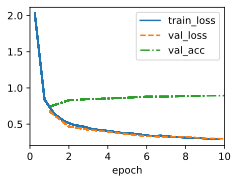

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **Exercises**

1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory.
    1. Compare the number of parameters needed for AlexNet and VGG.
    1. Compare the number of floating point operations used in the convolutional layers and in the fully connected layers.
    1. How could you reduce the computational cost created by the fully connected layers?
1. When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?
1. Use Table 1 in the VGG paper :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.
1. Upsampling the resolution in Fashion-MNIST eight-fold from $28 \times 28$ to $224 \times 224$ dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network? Consult the VGG paper :cite:`Simonyan.Zisserman.2014` for ideas on adding more nonlinearities prior to downsampling.

## **Exercises Solution**

1.1

In [ ]:
alexnet = AlexNet()
vgg = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))

# Create a dummy input to initialize the parameters (e.g., an image of size 224x224)
dummy_input = torch.randn(1, 3, 224, 224)  # 1 sample, 3 channels, 224x224 image

# Initialize AlexNet by running a forward pass
alexnet(dummy_input)

# Initialize VGG by running a forward pass
vgg(dummy_input)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
print("Number of parameters in AlexNet:", count_parameters(alexnet))
print("Number of parameters in VGG:", count_parameters(vgg))

Number of parameters in AlexNet: 46787978
Number of parameters in VGG: 43093610


1.2

In [ ]:
def calculate_flops(module, input_size):
    """Calculate FLOPs for Conv2D and Linear layers."""
    flops = 0
    if isinstance(module, nn.Conv2d):
        # Get the input channels, output channels, kernel size, etc.
        in_channels = module.in_channels
        out_channels = module.out_channels
        kernel_size = module.kernel_size[0] * module.kernel_size[1]
        stride = module.stride[0]
        padding = module.padding[0]

        # Calculate output feature map size (H_out, W_out)
        # Assume square input for simplicity
        input_height = input_size[2]  # from input (N, C, H, W)
        input_width = input_size[3]
        output_height = (input_height - module.kernel_size[0] + 2 * padding) // stride + 1
        output_width = (input_width - module.kernel_size[1] + 2 * padding) // stride + 1

        # FLOPs for Conv2D = 2 * C_in * H_out * W_out * K_h * K_w * C_out
        flops = 2 * in_channels * output_height * output_width * kernel_size * out_channels

    elif isinstance(module, nn.Linear):
        # FLOPs for Linear layer = 2 * in_features * out_features
        in_features = module.in_features
        out_features = module.out_features
        flops = 2 * in_features * out_features

    return flops

dummy_input = torch.randn(1, 3, 224, 224)  # Dummy input to simulate actual input size
input_size = dummy_input.size()

# FLOP calculations for AlexNet
conv_flops_alexnet = 0
fc_flops_alexnet = 0
for module in alexnet.modules():
    if isinstance(module, nn.Conv2d):
        conv_flops_alexnet += calculate_flops(module, input_size)
    elif isinstance(module, nn.Linear):
        fc_flops_alexnet += calculate_flops(module, input_size)

# FLOP calculations for VGG
conv_flops_vgg = 0
fc_flops_vgg = 0
for module in vgg.modules():
    if isinstance(module, nn.Conv2d):
        conv_flops_vgg += calculate_flops(module, input_size)
    elif isinstance(module, nn.Linear):
        fc_flops_vgg += calculate_flops(module, input_size)

# Output the results
print("Convolutional FLOPs in AlexNet:", conv_flops_alexnet)
print("Fully Connected FLOPs in AlexNet:", fc_flops_alexnet)
print("Convolutional FLOPs in VGG:", conv_flops_vgg)
print("Fully Connected FLOPs in VGG:", fc_flops_vgg)

Convolutional FLOPs in AlexNet: 372607097088
Fully Connected FLOPs in AlexNet: 86065152
Convolutional FLOPs in VGG: 57846104064
Fully Connected FLOPs in VGG: 85016576


1.3

- Reduce the number of neurons: One way to reduce the computational cost is to reduce the number of neurons in the fully connected layers. This can be done by reducing the number of hidden units or by using a smaller output size.

- Use convolutional layers instead: In some cases, fully connected layers can be replaced with convolutional layers. This is particularly useful when the input data has a spatial structure, such as images.

- Use sparse connections: Another way to reduce the computational cost is to use sparse connections between neurons. This can be done using sparse matrices or by using sparse neural networks.

- Use low-rank approximations: Low-rank approximations can be used to reduce the computational cost of fully connected layers. This involves approximating the weight matrix as a product of two low-rank matrices.

- Use knowledge distillation: Knowledge distillation involves training a smaller network (the student) to mimic the behavior of a larger network (the teacher). This can be used to reduce the computational cost of fully connected layers.-

2. The remaining three layers are the ReLU activation functions and the max pooling layers. These layers are not explicitly defined as separate modules in the network, but are instead used as functions within the **forward** method.

In [ ]:
for name, module in alexnet.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.MaxPool2d) or isinstance(module, nn.ReLU) or isinstance(module, nn.Linear):
        print(name, module)

net.0 Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
net.1 ReLU()
net.2 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
net.3 Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
net.4 ReLU()
net.5 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
net.6 Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.7 ReLU()
net.8 Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.9 ReLU()
net.10 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
net.11 ReLU()
net.12 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
net.14 Linear(in_features=6400, out_features=4096, bias=True)
net.15 ReLU()
net.17 Linear(in_features=4096, out_features=4096, bias=True)
net.18 ReLU()
net.20 Linear(in_features=4096, out_features=10, bias=True)


3.

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_layers):
        super(VGG, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        if num_layers == 16:
            self.conv_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        elif num_layers == 19:
            self.conv_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

        for v in self.conv_config:
            if v == 'M':
                self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.conv_layers.append(nn.Conv2d(v, v, kernel_size=3, padding=1))

        self.fc_config = [4096, 4096, 1000]
        for i in range(len(self.fc_config) - 1):
            self.fc_layers.append(nn.Linear(self.fc_config[i], self.fc_config[i+1]))

    def forward(self, x):
        for layer in self.conv_layers:
            if isinstance(layer, nn.MaxPool2d):
                x = layer(x)
            else:
                x = nn.functional.relu(layer(x))

        x = x.view(-1, 512 * 7 * 7)
        for layer in self.fc_layers:
            x = nn.functional.relu(layer(x))
            if layer != self.fc_layers[-1]:
                x = nn.functional.dropout(x, 0.5)

        return x

# Create VGG-16 model
vgg16 = VGG(16)

# Create VGG-19 model
vgg19 = VGG(19)

4.

In [2]:
# Define a custom transform to upsample the resolution to 56x56 or 84x84
class UpsampleTransform:
    def __init__(self, size):
        self.size = size

    def __call__(self, img):
        return transforms.Resize(self.size)(img)

# Define the network architecture
class VGG(nn.Module):
    def __init__(self, num_layers, input_size):
        super(VGG, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.fc_layers = nn.ModuleList()

        if num_layers == 16:
            self.conv_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        elif num_layers == 19:
            self.conv_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

        for v in self.conv_config:
            if v == 'M':
                self.conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                self.conv_layers.append(nn.Conv2d(v, v, kernel_size=3, padding=1))

        self.fc_config = [4096, 4096, 1000]
        for i in range(len(self.fc_config) - 1):
            self.fc_layers.append(nn.Linear(self.fc_config[i], self.fc_config[i+1]))

        # Add more nonlinearities prior to downsampling
        self.nonlinear_layers = nn.ModuleList()
        for i in range(len(self.conv_config)):
            if self.conv_config[i] == 'M':
                self.nonlinear_layers.append(nn.ReLU())

    def forward(self, x):
        for i, layer in enumerate(self.conv_layers):
            if isinstance(layer, nn.MaxPool2d):
                x = layer(x)
                x = self.nonlinear_layers[i](x)
            else:
                x = nn.functional.relu(layer(x))

        x = x.view(-1, 512 * (input_size // 32) * (input_size // 32))
        for layer in self.fc_layers:
            x = nn.functional.relu(layer(x))
            if layer != self.fc_layers[-1]:
                x = nn.functional.dropout(x, 0.5)

        return x

# Create a VGG-16 model with input size 56x56
vgg16_56 = VGG(16, 56)

# Create a VGG-16 model with input size 84x84
vgg16_84 = VGG(16, 84)

# Load the Fashion-MNIST dataset
transform = transforms.Compose([UpsampleTransform(56), transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

transform = transforms.Compose([UpsampleTransform(84), transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:07<00:00, 3319719.83it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 302776.17it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2502348.20it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4848928.14it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# **Network in Network (NiN)**

## **NiN Blocks**

In [3]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())

## **NiN Model**

In [4]:
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)

In [5]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## **Training**

In [ ]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

100%|██████████| 26421880/26421880 [00:01<00:00, 16536219.93it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 313308.00it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5676824.87it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10238158.84it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Exercises**

1. Why are there two $1\times 1$ convolutional layers per NiN block? Increase their number to three. Reduce their number to one. What changes?
1. What changes if you replace the $1 \times 1$ convolutions by $3 \times 3$ convolutions?
1. What happens if you replace the global average pooling by a fully connected layer (speed, accuracy, number of parameters)?
1. Calculate the resource usage for NiN.
    1. What is the number of parameters?
    1. What is the amount of computation?
    1. What is the amount of memory needed during training?
    1. What is the amount of memory needed during prediction?
1. What are possible problems with reducing the $384 \times 5 \times 5$ representation to a $10 \times 5 \times 5$ representation in one step?
1. Use the structural design decisions in VGG that led to VGG-11, VGG-16, and VGG-19 to design a family of NiN-like networks.

## **Exercises Solution**

1.

- Increase to Three 1×1 Convolutional Layers:

  Impact: Enhance the model's ability to learn deeper and more complex representations. This will likely improve accuracy on more complex tasks, but may lead to overfitting on simpler datasets, and could also slow down the training process due to increased parameters.

- Reduce to One 1×1 Convolutional Layer:

  Impact: Simplifies the model, lowering its capacity to capture complex patterns. This could speed up training but may reduce the model's ability to generalize on complex datasets.

In [ ]:
import torch
import torch.nn as nn

def nin_block(in_channels, out_channels, kernel_size, strides, padding, num_1x1=2):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU()
    ]
    for _ in range(num_1x1):
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=1))  # 1x1 convolution
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

class NiN(nn.Module):
    def __init__(self, num_classes=10, num_1x1=2):
        super(NiN, self).__init__()
        self.net = nn.Sequential(
            nin_block(3, 96, kernel_size=5, strides=1, padding=2, num_1x1=num_1x1),
            nn.MaxPool2d(3, stride=2),
            nin_block(96, 256, kernel_size=5, strides=1, padding=2, num_1x1=num_1x1),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, 384, kernel_size=3, strides=1, padding=1, num_1x1=num_1x1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(384, num_classes, kernel_size=3, strides=1, padding=1, num_1x1=num_1x1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)

# Test different configurations
for num_1x1 in [1, 2, 3]:
    print(f"Testing NiN with {num_1x1} 1x1 convolutions per block")
    model = NiN(num_1x1=num_1x1)
    dummy_input = torch.randn(1, 3, 28, 28)  # Example input for a 28x28 RGB image
    output = model(dummy_input)
    print(f"Output shape: {output.shape}\n")  # Should be [1, num_classes]


2. By replacing the 1×1 convolutions with 3×3 convolutions, you may enhance the model's ability to capture spatial relationships but at the cost of increased computational demands and a higher risk of overfitting.

In [ ]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),  # Using 3x3 convolution
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)   # Using 3x3 convolution
    )

class NiN(nn.Module):
    def __init__(self, num_classes=10):
        super(NiN, self).__init__()
        self.net = nn.Sequential(
            nin_block(3, 96, kernel_size=5, strides=1, padding=2),  # Accept 3-channel input
            nn.MaxPool2d(3, stride=2),  # Reduces size
            nin_block(96, 256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, 384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(384, num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),  # Pools to 1x1
            nn.Flatten()
        )

    def forward(self, x):
        return self.net(x)  # Define the forward pass

# Example of initializing and using the model
model = NiN()
dummy_input = torch.randn(1, 3, 28, 28)  # Example input for a 28x28 RGB image
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be [1, num_classes]


3.

In [ ]:
# Function to create a NiN block
def nin_block(in_channels, out_channels, kernel_size=3, strides=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

class NiNWithFC(nn.Module):
    def __init__(self, num_classes=10):
        super(NiNWithFC, self).__init__()
        self.net = nn.Sequential(
            nin_block(3, 96, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(96, 256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, 384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5)
        )
        self.fc_input_size = self._get_fc_input_size()
        self.fc = nn.Linear(self.fc_input_size, num_classes)  # Fully Connected Layer

    def _get_fc_input_size(self):
        # Create a dummy input to determine the size after convolutions
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 28, 28)  # Example input for a 28x28 image
            output = self.net(dummy_input)
            return output.numel()  # Total number of elements

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        return self.fc(x)

# Instantiate the NiN model with Fully Connected Layer
model_with_fc = NiNWithFC()

# Print number of parameters
print(f"Number of parameters in NiN with Fully Connected Layer: {count_parameters(model_with_fc)}")

# Test the output shape for a dummy input
dummy_input = torch.randn(1, 3, 28, 28)  # Example input for a 28x28 RGB image
output_fc = model_with_fc(dummy_input)

print(f"Output shape with FC: {output_fc.shape}")    # Should be [1, num_classes]


4.

In [ ]:
import numpy as np

def calculate_resource_usage(L, K, F, H, W, C, B):
    # Calculate number of parameters
    num_params = L * (K * F * F + K)

    # Calculate amount of computation
    num_flops = L * (K * F * F * H * W + K * H * W + K * H * W)

    # Calculate amount of memory needed during training
    mem_train = L * (B * H * W * C + K * F * F + K + B * K * H * W)

    # Calculate amount of memory needed during prediction
    mem_pred = L * (H * W * C + K * F * F + K)

    return num_params, num_flops, mem_train, mem_pred

# Example usage
L = 5  # number of layers
K = 32  # number of filters
F = 3  # filter size
H = 224  # input height
W = 224  # input width
C = 3  # number of channels
B = 32  # batch size

num_params, num_flops, mem_train, mem_pred = calculate_resource_usage(L, K, F, H, W, C, B)

print("Number of parameters:", num_params)
print("Amount of computation:", num_flops)
print("Amount of memory needed during training:", mem_train)
print("Amount of memory needed during prediction:", mem_pred)

5.

- Loss of Information:

  By reducing the number of filters from 384 to 10, we may lose important features and information in the data. This can result in a significant decrease in model performance.

- Increased Risk of Overfitting:

  With a smaller number of filters, the model may not have enough capacity to learn complex patterns in the data, leading to overfitting.

- Difficulty in Learning Hierarchical Representations:

  Convolutional neural networks (CNNs) learn hierarchical representations of the data by gradually reducing the spatial dimensions and increasing the number of filters. Reducing the number of filters too quickly can make it difficult for the model to learn these hierarchical representations.

- Gradient Explosion or Vanishing:

  When reducing the number of filters, the gradients may explode or vanish during backpropagation, making it difficult to train the model.

- Increased Computational Cost:

  Although reducing the number of filters may reduce the number of parameters, it can also increase the computational cost due to the larger spatial dimensions.

6.

In [ ]:
def nin_block(num_filters, kernel_size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(num_filters, kernel_size, activation='relu'),
        tf.keras.layers.Conv2D(num_filters, kernel_size, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2))
    ])

def nin_network(num_blocks, num_filters, kernel_size):
    model = tf.keras.Sequential()
    for _ in range(num_blocks):
        model.add(nin_block(num_filters, kernel_size))
    return model

# NiN-9
nin_9 = nin_network(3, 32, 3)

# NiN-13
nin_13 = nin_network(5, 64, 3)

# NiN-17
nin_17 = nin_network(7, 128, 3)

# **Multi-Branch Networks (GoogLeNet)**

## **Inception Blocks**

In [ ]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

## **GoogLeNet Model**

In [ ]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [ ]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [ ]:
model = GoogleNet().layer_summary((1, 1, 96, 96))

## **Training**

In [ ]:
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **Exercises**

1. GoogLeNet was so successful that it went through a number of iterations, progressively improving speed and accuracy. Try to implement and run some of them. They include the following:
    1. Add a batch normalization layer :cite:`Ioffe.Szegedy.2015`, as described later in :numref:`sec_batch_norm`.
    1. Make adjustments to the Inception block (width, choice and order of convolutions), as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    1. Use label smoothing for model regularization, as described in :citet:`Szegedy.Vanhoucke.Ioffe.ea.2016`.
    1. Make further adjustments to the Inception block by adding residual connection :cite:`Szegedy.Ioffe.Vanhoucke.ea.2017`, as described later in :numref:`sec_resnet`.
1. What is the minimum image size needed for GoogLeNet to work?
1. Can you design a variant of GoogLeNet that works on Fashion-MNIST's native resolution of $28 \times 28$ pixels? How would you need to change the stem, the body, and the head of the network, if anything at all?
1. Compare the model parameter sizes of AlexNet, VGG, NiN, and GoogLeNet. How do the latter two network
   architectures significantly reduce the model parameter size?
1. Compare the amount of computation needed in GoogLeNet and AlexNet. How does this affect the design of an accelerator chip, e.g., in terms of memory size, memory bandwidth, cache size, the amount of computation, and the benefit of specialized operations?

## **Exercises Solution**

1.

In [ ]:
# Define a basic Inception Block with Batch Normalization
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(ch3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(ch5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # Concatenate all branches along the channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        return outputs

# Define the GoogLeNet with Residual connections
class InceptionResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(InceptionResNetBlock, self).__init__()
        self.inception = InceptionBlock(in_channels, out_channels // 4, out_channels // 8, out_channels // 4,
                                        out_channels // 16, out_channels // 8, out_channels // 4)
        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.inception(x) + self.residual(x)

# Define the full GoogLeNet Model
class GoogLeNetModified(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNetModified, self).__init__()

        # Initial convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Inception Blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionResNetBlock(256, 480)  # Residual Block

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionResNetBlock(512, 512)  # Residual Block

        self.inception4c = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4d = InceptionResNetBlock(512, 512)  # Residual Block

        self.inception4e = InceptionBlock(512, 256, 160, 320, 32, 128, 128)

        # Final Inception Block with residual connection
        self.inception5a = InceptionResNetBlock(832, 832)
        self.inception5b = InceptionBlock(832, 256, 160, 320, 32, 128, 128)

        # Average Pooling Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(832, num_classes)

    def forward(self, x):
        # Pass through initial convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)

        # Pass through Inception and Residual blocks
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        # Final layers
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Label Smoothing Loss Function
def label_smoothing_loss(predictions, targets, smoothing=0.1):
    num_classes = predictions.size(1)
    confidence = 1.0 - smoothing
    smoothed_labels = torch.full(size=(targets.size(0), num_classes), fill_value=smoothing / (num_classes - 1)).to(predictions.device)
    smoothed_labels.scatter_(1, targets.unsqueeze(1), confidence)
    return F.kl_div(F.log_softmax(predictions, dim=1), smoothed_labels, reduction='batchmean')

# Instantiate the model and print its architecture
model = GoogLeNetModified(num_classes=10)
print(model)


2. The minimum input image size for GoogLeNet is 224 x 224 pixels.
If a smaller input size is needed, you must modify the network architecture, such as removing or adjusting some pooling or convolutional layers to accommodate the smaller input.

3.

In [ ]:
# Define a smaller Inception block tailored for Fashion-MNIST
class SmallInceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(SmallInceptionBlock, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(inplace=True)
        )

        # 1x1 convolution followed by 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(ch3x3_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(inplace=True)
        )

        # 1x1 convolution followed by 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(ch5x5_reduce),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(inplace=True)
        )

        # 3x3 max pooling followed by 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        # Concatenate all branches along the channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], 1)
        return outputs

# Define the GoogLeNet variant for Fashion-MNIST
class FashionMNISTGoogLeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FashionMNISTGoogLeNet, self).__init__()

        # Stem: Modify initial layers to handle 28x28 input size
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Changed kernel size and stride
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 14x14 feature map after pooling
        )

        # Inception blocks with fewer channels
        self.inception3a = SmallInceptionBlock(64, 32, 16, 32, 4, 8, 8)  # Output channels: 32 + 32 + 8 + 8 = 80
        self.inception3b = SmallInceptionBlock(80, 64, 32, 64, 8, 16, 16)  # Output channels: 64 + 64 + 16 + 16 = 160

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # 7x7 feature map after pooling

        # Final Inception blocks with fewer channels
        self.inception4a = SmallInceptionBlock(160, 128, 64, 128, 16, 32, 32)  # Output channels: 128 + 128 + 32 + 32 = 320

        # Head: Global average pooling and final classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 1x1 feature map
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(320, num_classes)  # Final classification layer

    def forward(self, x):
        # Forward pass through modified GoogLeNet for 28x28 inputs
        x = self.conv1(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        x = self.inception4a(x)

        # Average pooling, flatten, and pass through classifier
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Test the model with a random Fashion-MNIST size input
model = FashionMNISTGoogLeNet(num_classes=10)
print(model)

# Create a random 28x28 grayscale image (batch_size=1, channels=1, height=28, width=28)
test_input = torch.randn(1, 1, 28, 28)
output = model(test_input)
print(f"Output shape: {output.shape}")


4.

In [ ]:
import torch
import torch.nn as nn

# Define Network in Network (NiN)
class NiN(nn.Module):
    def __init__(self, num_classes=10):
        super(NiN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 192, kernel_size=5, stride=1, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(192, 160, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(160, 96, kernel_size=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 192, kernel_size=5, padding=2), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 192, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(192, 10, kernel_size=1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Linear(10, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create instances of the models
alexnet = models.alexnet(pretrained=False)
vgg16 = models.vgg16(pretrained=False)
nin = NiN(num_classes=10)
googlenet = models.googlenet(pretrained=False)

# Function to count total parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print parameter counts for each model
print(f"AlexNet parameters: {count_parameters(alexnet):,}")
print(f"VGG-16 parameters: {count_parameters(vgg16):,}")
print(f"NiN parameters: {count_parameters(nin):,}")
print(f"GoogLeNet parameters: {count_parameters(googlenet):,}")


5.

In [ ]:
import torch
from torchvision import models

# Create AlexNet and GoogLeNet models
alexnet = models.alexnet(pretrained=False)
googlenet = models.googlenet(pretrained=False)

# Use summary to display the number of parameters and shapes
print("AlexNet Summary:")
summary(alexnet, (3, 224, 224))

print("\nGoogLeNet Summary:")
summary(googlenet, (3, 224, 224))

# **Batch Normalization**

## **Implementation from Scratch**

In [ ]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [ ]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

## **LeNet with Batch Normalization**

In [ ]:
class BNLeNetScratch(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), BatchNorm(6, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16, num_dims=4),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120),
            BatchNorm(120, num_dims=2), nn.Sigmoid(), nn.LazyLinear(84),
            BatchNorm(84, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

In [ ]:
model.net[1].gamma.reshape((-1,)), model.net[1].beta.reshape((-1,))

## **Concise Implementation**

In [ ]:
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **Exercises**

1. Should we remove the bias parameter from the fully connected layer or the convolutional layer before the batch normalization? Why?
1. Compare the learning rates for LeNet with and without batch normalization.
    1. Plot the increase in validation accuracy.
    1. How large can you make the learning rate before the optimization fails in both cases?
1. Do we need batch normalization in every layer? Experiment with it.
1. Implement a "lite" version of batch normalization that only removes the mean, or alternatively one that
   only removes the variance. How does it behave?
1. Fix the parameters `beta` and `gamma`. Observe and analyze the results.
1. Can you replace dropout by batch normalization? How does the behavior change?
1. Research ideas: think of other normalization transforms that you can apply:
    1. Can you apply the probability integral transform?
    1. Can you use a full-rank covariance estimate? Why should you probably not do that?
    1. Can you use other compact matrix variants (block-diagonal, low-displacement rank, Monarch, etc.)?
    1. Does a sparsification compression act as a regularizer?
    1. Are there other projections (e.g., convex cone, symmetry group-specific transforms) that you can use?

## **Exercises Solution**

1. - Remove Bias Parameter: Set bias=False in convolutional and fully connected layers when using batch normalization.
  - Reason: The bias becomes redundant because batch normalization subtracts the mean, effectively neutralizing the effect of the bias parameter.

2.

In [ ]:
# Define LeNet without Batch Normalization
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define LeNet with Batch Normalization
class LeNetBN(nn.Module):
    def __init__(self):
        super(LeNetBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Define training and evaluation functions
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

# Define hyperparameters and dataset
batch_size = 32  # Reduced batch size for faster testing
epochs = 2       # Reduced number of epochs for faster testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define learning rates to test
learning_rates = [0.001, 0.01, 0.1, 0.5]  # Limited range of learning rates for quick testing
results_no_bn = []
results_bn = []

# Train and evaluate LeNet without Batch Normalization
for lr in learning_rates:
    model = LeNet().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"Training LeNet without BN with learning rate: {lr}")
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
    _, val_acc = evaluate(model, device, test_loader, criterion)
    results_no_bn.append(val_acc)

# Train and evaluate LeNet with Batch Normalization
for lr in learning_rates:
    model_bn = LeNetBN().to(device)
    optimizer = optim.SGD(model_bn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    print(f"Training LeNet with BN with learning rate: {lr}")
    for epoch in range(epochs):
        train(model_bn, device, train_loader, optimizer, criterion)
    _, val_acc = evaluate(model_bn, device, test_loader, criterion)
    results_bn.append(val_acc)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(learning_rates, results_no_bn, label='LeNet without BN', marker='o')
plt.plot(learning_rates, results_bn, label='LeNet with BN', marker='o')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy vs Learning Rate for LeNet with and without Batch Normalization')
plt.legend()
plt.grid(True)
plt.show()

3. using batch normalization in every layer may not always be necessary or beneficial. Overusing batch normalization can increase the computational overhead and memory usage without providing additional performance benefits.

In [ ]:
# Define LeNet without Batch Normalization (Baseline)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# LeNet with Batch Normalization on Convolutional Layers
class LeNetConvBN(nn.Module):
    def __init__(self):
        super(LeNetConvBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# LeNet with Batch Normalization on Fully Connected Layers
class LeNetFCBN(nn.Module):
    def __init__(self):
        super(LeNetFCBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.bn1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

# LeNet with Batch Normalization on All Layers
class LeNetAllBN(nn.Module):
    def __init__(self):
        super(LeNetAllBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.bn3(self.fc1(x)))
        x = torch.relu(self.bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training and evaluation functions (same as before)
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Dataset and DataLoader setup
batch_size = 32
epochs = 2  # Shortened for quick testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Test various configurations
configs = {
    'No BN': LeNet(),
    'Conv BN': LeNetConvBN(),
    'FC BN': LeNetFCBN(),
    'All BN': LeNetAllBN()
}

learning_rate = 0.01
results = {}

# Training and evaluation
for config_name, model in configs.items():
    print(f"\nTraining {config_name} model...")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
    accuracy = evaluate(model, device, test_loader, criterion)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Accuracy for {config_name}: {accuracy:.2f}%, Training time: {training_time:.2f} seconds")
    results[config_name] = accuracy

# Plot the results
plt.bar(results.keys(), results.values())
plt.xlabel('Model Configuration')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy of Different Batch Normalization Configurations')
plt.show()


4.

In [ ]:
# Define a "lite" version of batch normalization that only removes the mean
class MeanOnlyNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(MeanOnlyNormalization, self).__init__()
        self.eps = eps  # Small constant to prevent division by zero
        self.gamma = nn.Parameter(torch.ones(num_features))  # Scale parameter (optional)
        self.beta = nn.Parameter(torch.zeros(num_features))  # Shift parameter (optional)

    def forward(self, x):
        # Determine if the input is from a convolutional or fully connected layer
        if len(x.shape) == 4:  # Convolutional layer input (batch_size, channels, height, width)
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            x = x - mean  # Subtract mean
            # Reshape gamma and beta to match the input shape (1, channels, 1, 1)
            return self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        elif len(x.shape) == 2:  # Fully connected layer input (batch_size, features)
            mean = x.mean(dim=0, keepdim=True)
            x = x - mean  # Subtract mean
            # Use gamma and beta as is for fully connected layer
            return self.gamma * x + self.beta
        else:
            raise ValueError("Unsupported input shape for MeanOnlyNormalization.")

# Define a "lite" version of batch normalization that only removes the variance
class VarianceOnlyNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(VarianceOnlyNormalization, self).__init__()
        self.eps = eps  # Small constant to prevent division by zero
        self.gamma = nn.Parameter(torch.ones(num_features))  # Scale parameter (optional)
        self.beta = nn.Parameter(torch.zeros(num_features))  # Shift parameter (optional)

    def forward(self, x):
        # Determine if the input is from a convolutional or fully connected layer
        if len(x.shape) == 4:  # Convolutional layer input (batch_size, channels, height, width)
            var = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)
            x = x / torch.sqrt(var + self.eps)  # Scale by variance
            # Reshape gamma and beta to match the input shape (1, channels, 1, 1)
            return self.gamma.view(1, -1, 1, 1) * x + self.beta.view(1, -1, 1, 1)
        elif len(x.shape) == 2:  # Fully connected layer input (batch_size, features)
            var = x.var(dim=0, keepdim=True, unbiased=False)
            x = x / torch.sqrt(var + self.eps)  # Scale by variance
            # Use gamma and beta as is for fully connected layer
            return self.gamma * x + self.beta
        else:
            raise ValueError("Unsupported input shape for VarianceOnlyNormalization.")

# LeNet model using Mean-Only Normalization
class LeNetMeanOnlyBN(nn.Module):
    def __init__(self):
        super(LeNetMeanOnlyBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.mean_bn1 = MeanOnlyNormalization(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.mean_bn2 = MeanOnlyNormalization(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.mean_bn3 = MeanOnlyNormalization(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.mean_bn4 = MeanOnlyNormalization(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.mean_bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.mean_bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.mean_bn3(self.fc1(x)))
        x = torch.relu(self.mean_bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# LeNet model using Variance-Only Normalization
class LeNetVarianceOnlyBN(nn.Module):
    def __init__(self):
        super(LeNetVarianceOnlyBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.var_bn1 = VarianceOnlyNormalization(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.var_bn2 = VarianceOnlyNormalization(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.var_bn3 = VarianceOnlyNormalization(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.var_bn4 = VarianceOnlyNormalization(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.var_bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.var_bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.var_bn3(self.fc1(x)))
        x = torch.relu(self.var_bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training and evaluation functions (same as before)
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Dataset and DataLoader setup
batch_size = 32
epochs = 2  # Shortened for quick testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Test different batch normalization configurations
configs = {
    'Mean-Only Normalization': LeNetMeanOnlyBN(),
    'Variance-Only Normalization': LeNetVarianceOnlyBN()
}

learning_rate = 0.01
results = {}

# Training and evaluation
for config_name, model in configs.items():
    print(f"\nTraining {config_name} model...")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
    accuracy = evaluate(model, device, test_loader, criterion)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Accuracy for {config_name}: {accuracy:.2f}%, Training time: {training_time:.2f} seconds")
    results[config_name] = accuracy

# Plot the results
plt.bar(results.keys(), results.values())
plt.xlabel('Model Configuration')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy of Mean-Only vs Variance-Only Normalization')
plt.show()


5.

In [ ]:
# Define a "lite" version of batch normalization that only removes the mean
# Here, `gamma` is fixed to 1 and `beta` is fixed to 0.
class MeanOnlyNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(MeanOnlyNormalization, self).__init__()
        self.eps = eps  # Small constant to prevent division by zero

    def forward(self, x):
        # Determine if the input is from a convolutional or fully connected layer
        if len(x.shape) == 4:  # Convolutional layer input (batch_size, channels, height, width)
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            x = x - mean  # Subtract mean
        elif len(x.shape) == 2:  # Fully connected layer input (batch_size, features)
            mean = x.mean(dim=0, keepdim=True)
            x = x - mean  # Subtract mean
        else:
            raise ValueError("Unsupported input shape for MeanOnlyNormalization.")
        return x  # No scaling or shifting (gamma=1, beta=0)

# Define a "lite" version of batch normalization that only removes the variance
# Here, `gamma` is fixed to 1 and `beta` is fixed to 0.
class VarianceOnlyNormalization(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(VarianceOnlyNormalization, self).__init__()
        self.eps = eps  # Small constant to prevent division by zero

    def forward(self, x):
        # Determine if the input is from a convolutional or fully connected layer
        if len(x.shape) == 4:  # Convolutional layer input (batch_size, channels, height, width)
            var = x.var(dim=(0, 2, 3), keepdim=True, unbiased=False)
            x = x / torch.sqrt(var + self.eps)  # Scale by variance
        elif len(x.shape) == 2:  # Fully connected layer input (batch_size, features)
            var = x.var(dim=0, keepdim=True, unbiased=False)
            x = x / torch.sqrt(var + self.eps)  # Scale by variance
        else:
            raise ValueError("Unsupported input shape for VarianceOnlyNormalization.")
        return x  # No shifting (beta=0)

# LeNet model using Mean-Only Normalization (Fixed Parameters)
class LeNetMeanOnlyBN(nn.Module):
    def __init__(self):
        super(LeNetMeanOnlyBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.mean_bn1 = MeanOnlyNormalization(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.mean_bn2 = MeanOnlyNormalization(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.mean_bn3 = MeanOnlyNormalization(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.mean_bn4 = MeanOnlyNormalization(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.mean_bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.mean_bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.mean_bn3(self.fc1(x)))
        x = torch.relu(self.mean_bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# LeNet model using Variance-Only Normalization (Fixed Parameters)
class LeNetVarianceOnlyBN(nn.Module):
    def __init__(self):
        super(LeNetVarianceOnlyBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2, bias=False)
        self.var_bn1 = VarianceOnlyNormalization(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)
        self.var_bn2 = VarianceOnlyNormalization(16)
        self.fc1 = nn.Linear(16*5*5, 120, bias=False)
        self.var_bn3 = VarianceOnlyNormalization(120)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.var_bn4 = VarianceOnlyNormalization(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.var_bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.var_bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = torch.relu(self.var_bn3(self.fc1(x)))
        x = torch.relu(self.var_bn4(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training and evaluation functions (same as before)
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

# Dataset and DataLoader setup
batch_size = 32
epochs = 2  # Shortened for quick testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Fashion-MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Test different batch normalization configurations
configs = {
    'Mean-Only Normalization (Fixed)': LeNetMeanOnlyBN(),
    'Variance-Only Normalization (Fixed)': LeNetVarianceOnlyBN()
}

learning_rate = 0.01
results = {}

# Training and evaluation
for config_name, model in configs.items():
    print(f"\nTraining {config_name} model...")
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, criterion)
    accuracy = evaluate(model, device, test_loader, criterion)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"Accuracy for {config_name}: {accuracy:.2f}%, Training time: {training_time:.2f} seconds")
    results[config_name] = accuracy

# Plot the results
plt.bar(results.keys(), results.values())
plt.xlabel('Model Configuration')
plt.ylabel('Validation Accuracy (%)')
plt.title('Validation Accuracy of Mean-Only vs Variance-Only Normalization (Fixed Parameters)')
plt.show()


7. The Probability Integral Transform (PIT) can be applied to normalize activations by mapping them to a uniform distribution based on their cumulative distribution function (CDF), but it requires accurate PDF or CDF estimation, which is computationally intensive and may introduce instability for high-dimensional data. Using a full-rank covariance estimate for normalization provides complete whitening of features, but it is typically avoided due to its high computational cost, numerical instability, and excessive memory requirements, especially for large models. Instead, compact matrix variants like block-diagonal, low-displacement rank, and Monarch matrices can approximate full-rank covariance matrices while being more efficient and scalable. Sparsification techniques, where a subset of weights or activations are set to zero, can serve as a form of regularization by reducing model complexity and overfitting, but they require careful handling during normalization. Other approaches, such as projections onto convex cones or using group-specific symmetry transforms, can enforce desired properties in activations, such as non-negativity or rotational invariance, and may enhance performance for certain types of data. However, these methods need to be chosen based on the specific model architecture and dataset properties to be effective.

# **Residual Networks (ResNet) and ResNext**

## **Residual Blocks**

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

## **ResNet Model**

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

## **Training**

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

## **ResNeXt**

In [ ]:
class ResNeXtBlock(nn.Module):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = nn.LazyConv2d(bot_channels, kernel_size=1, stride=1)
        self.conv2 = nn.LazyConv2d(bot_channels, kernel_size=3,
                                   stride=strides, padding=1,
                                   groups=bot_channels//groups)
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=1)
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        self.bn3 = nn.LazyBatchNorm2d()
        if use_1x1conv:
            self.conv4 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
            self.bn4 = nn.LazyBatchNorm2d()
        else:
            self.conv4 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = F.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return F.relu(Y + X)

In [ ]:
blk = ResNeXtBlock(32, 16, 1)
X = torch.randn(4, 32, 96, 96)
blk(X).shape

## **Exercises**

1. What are the major differences between the Inception block in :numref:`fig_inception` and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?
1. Refer to Table 1 in the ResNet paper :cite:`He.Zhang.Ren.ea.2016` to implement different variants of the network.
1. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce model complexity. Try to implement it.
1. In subsequent versions of ResNet, the authors changed the "convolution, batch normalization, and activation" structure to the "batch normalization, activation, and convolution" structure. Make this improvement yourself. See Figure 1 in :citet:`He.Zhang.Ren.ea.2016*1` for details.
1. Why can't we just increase the complexity of functions without bound, even if the function classes are nested?


## **Exercises Solution**

1. the Inception block and the residual block have different design philosophies: the Inception block focuses on capturing multi-scale information through parallel convolutions, while the residual block aims to address the vanishing gradient problem and facilitate the learning of deep networks by preserving information through skip connections. In terms of computation, the Inception block can be more computationally intensive, but it provides flexibility in feature extraction, while the residual block is more efficient and suitable for very deep architectures. In terms of the functions they can describe, the Inception block is better at capturing diverse spatial features, whereas the residual block excels at learning refined features and deep representations.

2.

In [ ]:
# Define the Basic Block used for ResNet-18 and ResNet-34
class BasicBlock(nn.Module):
    expansion = 1  # No expansion in basic block

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First 3x3 convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # Second 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # Optional downsample for residual connection

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out

# Define the Bottleneck Block used for deeper ResNet architectures
class BottleneckBlock(nn.Module):
    expansion = 4  # Expansion factor for the output channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()
        # 1x1 convolution for reduction
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3x3 convolution for spatial feature extraction
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1x1 convolution for restoring channel depth
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # Optional downsample for residual connection

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)
        return out

# Define the ResNet model class that combines the blocks into layers
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution and pooling layers
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])   # conv2_x
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # conv3_x
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # conv4_x
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # conv5_x

        # Final pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        # Create a ResNet layer with the given number of blocks
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))  # First block
        self.in_channels = out_channels * block.expansion  # Update in_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))  # Remaining blocks

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Functions to create different ResNet variants
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def resnet50(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

# Testing the implementation with a dummy input
if __name__ == "__main__":
    # Create ResNet-50 and print the architecture
    model = resnet50()
    print(model)

    # Test with a dummy input tensor of shape [1, 3, 224, 224]
    dummy_input = torch.randn(1, 3, 224, 224)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 1000] for 1000 ImageNet


3.

In [ ]:
# Define the Bottleneck Block used in deeper ResNet variants like ResNet-50, ResNet-101, and ResNet-152
class BottleneckBlock(nn.Module):
    # Each bottleneck block has an expansion factor of 4
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initializes a bottleneck block.

        Parameters:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        - stride: Stride for the first convolutional layer in the block.
        - downsample: Downsample layer to match dimensions of the input and output (if necessary).
        """
        super(BottleneckBlock, self).__init__()
        # 1x1 Convolution (Dimensionality Reduction)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 Convolution (Feature Extraction)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 Convolution (Dimensionality Restoration)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample  # Downsample layer for matching input-output dimensions

    def forward(self, x):
        identity = x

        # 1x1 Convolution (Reduction)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 3x3 Convolution (Spatial Feature Extraction)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 1x1 Convolution (Restoration)
        out = self.conv3(out)
        out = self.bn3(out)

        # If downsample is specified, apply it to match dimensions
        if self.downsample is not None:
            identity = self.downsample(x)

        # Add the skip connection (identity mapping)
        out += identity
        out = self.relu(out)
        return out

# Example Usage: Implement a ResNet Layer using Bottleneck Blocks
class ResNetBottleneck(nn.Module):
    def __init__(self, layers, num_classes=1000):
        """
        Initializes a simple ResNet architecture using Bottleneck blocks.

        Parameters:
        - layers: List defining the number of blocks in each layer (e.g., [3, 4, 6, 3] for ResNet-50).
        - num_classes: Number of output classes.
        """
        super(ResNetBottleneck, self).__init__()
        self.in_channels = 64  # Initial number of channels after the first convolution

        # Initial convolution and pooling layers
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers using Bottleneck blocks
        self.layer1 = self._make_layer(BottleneckBlock, 64, layers[0])   # conv2_x
        self.layer2 = self._make_layer(BottleneckBlock, 128, layers[1], stride=2)  # conv3_x
        self.layer3 = self._make_layer(BottleneckBlock, 256, layers[2], stride=2)  # conv4_x
        self.layer4 = self._make_layer(BottleneckBlock, 512, layers[3], stride=2)  # conv5_x

        # Average pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BottleneckBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """Creates a ResNet layer with multiple Bottleneck blocks."""
        downsample = None
        # Define downsample layer if input and output dimensions differ
        if stride != 1 or self.in_channels != out_channels * BottleneckBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * BottleneckBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleneckBlock.expansion),
            )

        # First block of the layer, applying stride and downsample if needed
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * BottleneckBlock.expansion  # Update in_channels

        # Add remaining blocks in the layer
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Define ResNet-50, ResNet-101, and ResNet-152 using Bottleneck blocks
def resnet50(num_classes=1000):
    """ResNet-50 configuration: [3, 4, 6, 3]"""
    return ResNetBottleneck([3, 4, 6, 3], num_classes)

def resnet101(num_classes=1000):
    """ResNet-101 configuration: [3, 4, 23, 3]"""
    return ResNetBottleneck([3, 4, 23, 3], num_classes)

def resnet152(num_classes=1000):
    """ResNet-152 configuration: [3, 8, 36, 3]"""
    return ResNetBottleneck([3, 8, 36, 3], num_classes)

# Testing the implementation with a dummy input
if __name__ == "__main__":
    # Create ResNet-50 and print the architecture
    model = resnet50()
    print(model)

    # Test with a dummy input tensor of shape [1, 3, 224, 224]
    dummy_input = torch.randn(1, 3, 224, 224)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 1000] for 1000 ImageNet classes


4.

In [ ]:
import torch
import torch.nn as nn

# Define the Pre-activation Basic Block used in newer ResNet architectures (e.g., ResNet-18, ResNet-34)
class PreActBasicBlock(nn.Module):
    expansion = 1  # No expansion in basic block

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PreActBasicBlock, self).__init__()
        # Pre-activation layers: batchnorm → relu → conv
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # Second pre-activation: batchnorm → relu → conv
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)

        self.downsample = downsample  # Optional downsample for residual connection

    def forward(self, x):
        identity = x

        # Pre-activation before the first convolution
        out = self.bn1(x)
        out = self.relu(out)

        # If downsampling exists, apply it to identity first (note: position changed)
        if self.downsample is not None:
            identity = self.downsample(out)

        out = self.conv1(out)

        # Pre-activation before the second convolution
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # Add the residual (identity mapping)
        out += identity
        return out

# Define the Pre-activation Bottleneck Block used for deeper ResNet variants
class PreActBottleneckBlock(nn.Module):
    expansion = 4  # Expansion factor for output channels

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(PreActBottleneckBlock, self).__init__()
        # Pre-activation: batchnorm → relu → conv (1x1 reduction)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        # Pre-activation: batchnorm → relu → conv (3x3 spatial feature extraction)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # Pre-activation: batchnorm → relu → conv (1x1 restoration)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)

        self.downsample = downsample  # Optional downsample for residual connection

    def forward(self, x):
        identity = x

        # Pre-activation before the first convolution
        out = self.bn1(x)
        out = self.relu(out)

        # If downsampling exists, apply it to identity first (note: position changed)
        if self.downsample is not None:
            identity = self.downsample(out)

        out = self.conv1(out)

        # Pre-activation before the second convolution
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        # Pre-activation before the third convolution
        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        # Add the residual (identity mapping)
        out += identity
        return out

# Define the ResNet model with Pre-activation blocks
class PreActResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(PreActResNet, self).__init__()
        self.in_channels = 64

        # Initial convolution and pooling layers
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create the Pre-activation ResNet layers
        self.layer1 = self._make_layer(block, 64, layers[0])   # conv2_x
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)  # conv3_x
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)  # conv4_x
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)  # conv5_x

        # Final pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        # Create a ResNet layer with the given number of blocks
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))  # First block
        self.in_channels = out_channels * block.expansion  # Update in_channels

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))  # Remaining blocks

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Functions to create different Pre-activation ResNet variants
def preact_resnet18(num_classes=1000):
    return PreActResNet(PreActBasicBlock, [2, 2, 2, 2], num_classes)

def preact_resnet34(num_classes=1000):
    return PreActResNet(PreActBasicBlock, [3, 4, 6, 3], num_classes)

def preact_resnet50(num_classes=1000):
    return PreActResNet(PreActBottleneckBlock, [3, 4, 6, 3], num_classes)

def preact_resnet101(num_classes=1000):
    return PreActResNet(PreActBottleneckBlock, [3, 4, 23, 3], num_classes)

def preact_resnet152(num_classes=1000):
    return PreActResNet(PreActBottleneckBlock, [3, 8, 36, 3], num_classes)

# Testing the implementation with a dummy input
if __name__ == "__main__":
    # Create Pre-activation ResNet-50 and print the architecture
    model = preact_resnet50()
    print(model)

    # Test with a dummy input tensor of shape [1, 3, 224, 224]
    dummy_input = torch.randn(1, 3, 224, 224)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}")  # Should be [1, 1000] for 1000 ImageNet classes


5. Even if function classes are nested, increasing complexity without bound leads to overfitting, optimization issues, and practical computational constraints. Therefore, while nested function classes provide more expressive power, in practice, it’s crucial to balance complexity with model generalization and training stability. Regularization techniques, constraints on model size, and careful design are necessary to ensure the model performs well in both training and deployment scenarios.

# **Densely Connected Networks (DenseNet)**

## **Dense Blocks**

In [ ]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [ ]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [ ]:
blk = DenseBlock(2, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

## **Transition Layers**

In [ ]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [ ]:
blk = transition_block(10)
blk(Y).shape

## **DenseNet Model**

In [ ]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## **Training**

In [ ]:
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## **Exercises**

1. Why do we use average pooling rather than max-pooling in the transition layer?
1. One of the advantages mentioned in the DenseNet paper is that its model parameters are smaller than those of ResNet. Why is this the case?
1. One problem for which DenseNet has been criticized is its high memory consumption.
    1. Is this really the case? Try to change the input shape to $224\times 224$ to compare the actual GPU memory consumption empirically.
    1. Can you think of an alternative means of reducing the memory consumption? How would you need to change the framework?
1. Implement the various DenseNet versions presented in Table 1 of the DenseNet paper :cite:`Huang.Liu.Van-Der-Maaten.ea.2017`.
1. Design an MLP-based model by applying the DenseNet idea. Apply it to the housing price prediction task in :numref:`sec_kaggle_house`.


## **Exercises Solution**

1. average pooling is used in transition layers to achieve a more stable, consistent, and smooth representation of the feature maps, which helps in effective dimensionality reduction and prevents overfitting. It maintains global context, reduces variance, and ensures smoother gradient flow, making it more suitable for transition layers than max-pooling, which can introduce abrupt changes and information loss.

2. DenseNet achieves parameter efficiency through:

- Dense Connectivity, which encourages feature reuse and reduces redundancy.
- Controlled Growth Rate, which limits the number of new features each layer generates.
- Efficient Use of Transition Layers, which reduce the number of channels and prevent parameter explosion.

3. DenseNet’s high memory consumption results from its dense connectivity pattern and the rapid increase in the number of feature maps as layers are concatenated. To reduce memory usage, consider using bottleneck layers, gradient checkpointing, or compressing transition layers. These strategies help balance memory efficiency with model performance, making DenseNet more suitable for deployment in memory-constrained environments.

In [ ]:
# Function to measure memory usage in MB
def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # in MB

# Initialize a DenseNet model
model = models.densenet121(pretrained=False)

# Define input shape 224x224 with 3 channels (RGB)
input_shape = (1, 3, 224, 224)  # Batch size = 1
input_tensor = torch.randn(input_shape)

# Measure memory before the model
memory_before = get_memory_usage()

# Run a forward pass without torch.no_grad() to track full memory usage
output = model(input_tensor)

# Measure memory after the model
memory_after = get_memory_usage()

print(f"Memory usage before model: {memory_before:.2f} MB")
print(f"Memory usage after model: {memory_after:.2f} MB")
print(f"Total memory used by the model: {memory_after - memory_before:.2f} MB")


4.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic Dense Layer
class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(_DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        new_features = self.conv2(self.bn2(self.relu(self.conv1(self.bn1(self.relu(x))))))
        return torch.cat([x, new_features], 1)

# Dense Block
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([_DenseLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Transition Layer
class _Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(self.conv(self.relu(self.bn(x))))
        return x

# Main DenseNet Model
class DenseNet(nn.Module):
    def __init__(self, block_config, growth_rate=32, num_init_features=64, num_classes=1000):
        super(DenseNet, self).__init__()

        # Initial Convolution and Pooling
        self.features = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Dense Blocks and Transition Layers
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            self.features.add_module(f'denseblock{i+1}', _DenseBlock(num_layers, num_features, growth_rate))
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                self.features.add_module(f'transition{i+1}', _Transition(num_features, num_features // 2))
                num_features = num_features // 2

        # Final BatchNorm and Linear Layer
        self.features.add_module('bn5', nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

# Dictionary to hold the configurations for different DenseNet models
densenet_configs = {
    'densenet121': [6, 12, 24, 16],
    'densenet169': [6, 12, 32, 32],
    'densenet201': [6, 12, 48, 32],
    'densenet264': [6, 12, 64, 48]
}

# Function to create DenseNet model based on the chosen configuration
def get_densenet(model_name='densenet121', num_classes=1000):
    config = densenet_configs[model_name]
    return DenseNet(config, growth_rate=32, num_init_features=64, num_classes=num_classes)

# Example usage
model = get_densenet('densenet121')
print(model)


5.

In [ ]:
# Step 1: Load and preprocess the dataset
# Load the dataset
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
housing = pd.read_csv(url)

# Preprocessing
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
housing = housing.dropna()  # Remove missing values for simplicity

# One-hot encoding for categorical features
housing = pd.get_dummies(housing, columns=["ocean_proximity"])

# Split into features and labels
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Step 2: Define the MLP DenseNet-inspired Model
class MLPDenseNet(nn.Module):
    def __init__(self, input_dim, growth_rate=32, num_layers=4):
        super(MLPDenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.dense_layers = nn.ModuleList()

        # First dense layer
        self.dense_layers.append(nn.Linear(input_dim, growth_rate))

        # Create subsequent dense layers
        for i in range(1, num_layers):
            self.dense_layers.append(nn.Linear(growth_rate * i + input_dim, growth_rate))

        # Final regression layer
        self.output_layer = nn.Linear(growth_rate * num_layers + input_dim, 1)

    def forward(self, x):
        # Initial input
        concat_features = x
        for layer in self.dense_layers:
            new_features = torch.relu(layer(concat_features))
            concat_features = torch.cat([concat_features, new_features], dim=1)  # Concatenate input and new features
        # Final prediction
        output = self.output_layer(concat_features)
        return output

# Step 3: Initialize and train the model
input_dim = X_train.shape[1]
model = MLPDenseNet(input_dim=input_dim, growth_rate=32, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Step 4: Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = mean_squared_error(y_test_tensor, predictions)
    print(f'Test MSE: {test_loss:.4f}')


# **Designing Convolution Networks Architectures**

## **The AnyNet Design Space**

In [ ]:
class AnyNet(d2l.Classifier):
    def stem(self, num_channels):
        return nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU())

In [ ]:
@d2l.add_to_class(AnyNet)
def stage(self, depth, num_channels, groups, bot_mul):
    blk = []
    for i in range(depth):
        if i == 0:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul,
                use_1x1conv=True, strides=2))
        else:
            blk.append(d2l.ResNeXtBlock(num_channels, groups, bot_mul))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(AnyNet)
def __init__(self, arch, stem_channels, lr=0.1, num_classes=10):
    super(AnyNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.stem(stem_channels))
    for i, s in enumerate(arch):
        self.net.add_module(f'stage{i+1}', self.stage(*s))
    self.net.add_module('head', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

## **RegNet**

In [ ]:
class RegNetX32(AnyNet):
    def __init__(self, lr=0.1, num_classes=10):
        stem_channels, groups, bot_mul = 32, 16, 1
        depths, channels = (4, 6), (32, 80)
        super().__init__(
            ((depths[0], channels[0], groups, bot_mul),
             (depths[1], channels[1], groups, bot_mul)),
            stem_channels, lr, num_classes)

In [ ]:
RegNetX32().layer_summary((1, 1, 96, 96))

## **Training**

In [ ]:
model = RegNetX32(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

## **Exercises**

1. Increase the number of stages to four. Can you design a deeper RegNetX that performs better?
1. De-ResNeXt-ify RegNets by replacing the ResNeXt block with the ResNet block. How does your new model perform?
1. Implement multiple instances of a "VioNet" family by *violating* the design principles of RegNetX. How do they perform? Which of ($d_i$, $c_i$, $g_i$, $b_i$) is the most important factor?
1. Your goal is to design the "perfect" MLP. Can you use the design principles introduced above to find good architectures? Is it possible to extrapolate from small to large networks?

## **Exercises Solution**

1.

In [ ]:
class RegNetX(nn.Module):
    def __init__(self, num_classes=1000):
        super(RegNetX, self).__init__()

        # Stem layer
        self.stem = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.stem_bn = nn.BatchNorm2d(32)
        self.stem_relu = nn.ReLU(inplace=True)

        # Stage 1
        self.stage1 = self._make_stage(32, 48, num_blocks=2, stride=2, bottleneck_ratio=1/4)

        # Stage 2
        self.stage2 = self._make_stage(48, 96, num_blocks=4, stride=2, bottleneck_ratio=1/4)

        # Stage 3
        self.stage3 = self._make_stage(96, 192, num_blocks=6, stride=2, bottleneck_ratio=1/4)

        # Stage 4
        self.stage4 = self._make_stage(192, 384, num_blocks=8, stride=2, bottleneck_ratio=1/4)

        # Global Average Pooling & Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(384, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, bottleneck_ratio):
        layers = []
        layers.append(self._make_block(in_channels, out_channels, stride, bottleneck_ratio))
        for _ in range(1, num_blocks):
            layers.append(self._make_block(out_channels, out_channels, stride=1, bottleneck_ratio=bottleneck_ratio))
        return nn.Sequential(*layers)

    def _make_block(self, in_channels, out_channels, stride, bottleneck_ratio):
        bottleneck_channels = int(out_channels * bottleneck_ratio)
        return nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.stem_relu(self.stem_bn(self.stem(x)))
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


2.

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, bottleneck_ratio=1/4):
        super(ResNetBlock, self).__init__()
        bottleneck_channels = int(out_channels * bottleneck_ratio)

        # First 1x1 Convolution
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        # Standard 3x3 Convolution
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        # Second 1x1 Convolution
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class DeResNeXtifiedRegNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(DeResNeXtifiedRegNet, self).__init__()

        # Stem layer
        self.stem = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.stem_bn = nn.BatchNorm2d(32)
        self.stem_relu = nn.ReLU(inplace=True)

        # Stage 1
        self.stage1 = self._make_stage(32, 48, num_blocks=2, stride=2)

        # Stage 2
        self.stage2 = self._make_stage(48, 96, num_blocks=4, stride=2)

        # Stage 3
        self.stage3 = self._make_stage(96, 192, num_blocks=6, stride=2)

        # Stage 4
        self.stage4 = self._make_stage(192, 384, num_blocks=8, stride=2)

        # Global Average Pooling & Fully Connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(384, num_classes)

    def _make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem_relu(self.stem_bn(self.stem(x)))
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


3.

In [ ]:
# Define the custom VioNet block
class VioNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, group_width, bottleneck_ratio):
        super(VioNetBlock, self).__init__()
        # Implement bottleneck block structure with variable group width and bottleneck ratio
        mid_channels = int(out_channels * bottleneck_ratio)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=1, padding=1, groups=group_width, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return F.relu(out)

# Define VioNet model with flexible architecture parameters
class VioNet(nn.Module):
    def __init__(self, num_classes=10, depths=[2, 2, 2], widths=[64, 128, 256], group_widths=[8, 16, 32], bottleneck_ratios=[0.5, 0.5, 0.5]):
        super(VioNet, self).__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, widths[0], kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(widths[0]),
            nn.ReLU()
        )

        self.layers = self._make_layers(depths, widths, group_widths, bottleneck_ratios)
        self.fc = nn.Linear(widths[-1], num_classes)

    def _make_layers(self, depths, widths, group_widths, bottleneck_ratios):
        layers = []
        in_channels = widths[0]
        for i, depth in enumerate(depths):
            for _ in range(depth):
                layers.append(VioNetBlock(in_channels, widths[i], group_widths[i], bottleneck_ratios[i]))
                in_channels = widths[i]
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.layers(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# Create multiple instances of VioNet with varying configurations
def create_vionet_instances():
    # Define configurations violating RegNetX principles
    configs = [
        {'depths': [1, 3, 4], 'widths': [64, 128, 256], 'group_widths': [16, 32, 64], 'bottleneck_ratios': [0.5, 0.5, 0.5]},
        {'depths': [2, 2, 2], 'widths': [32, 128, 512], 'group_widths': [8, 16, 32], 'bottleneck_ratios': [1.0, 1.0, 1.0]},
        {'depths': [4, 4, 4], 'widths': [128, 256, 512], 'group_widths': [32, 32, 32], 'bottleneck_ratios': [0.25, 0.25, 0.25]}
    ]

    models = []
    for config in configs:
        model = VioNet(depths=config['depths'], widths=config['widths'], group_widths=config['group_widths'], bottleneck_ratios=config['bottleneck_ratios'])
        models.append(model)

    return models

# Example usage: create multiple VioNet models
vionet_models = create_vionet_instances()

# Print model summaries to verify configurations
for i, model in enumerate(vionet_models):
    print(f"VioNet Model {i+1} Configuration:")
    print(model)


4.

In [ ]:
# Create a simple synthetic dataset for testing purposes
def create_synthetic_data(n_samples=1000, input_dim=100, num_classes=10):
    X = np.random.randn(n_samples, input_dim).astype(np.float32)
    y = np.random.randint(0, num_classes, size=n_samples).astype(np.int64)
    return torch.tensor(X), torch.tensor(y)

# Define the MLP architecture with customizable depth and width
class CustomMLP(nn.Module):
    def __init__(self, input_dim=100, num_classes=10, depths=[3], widths=[256], bottleneck_ratios=None, dropout=0.1):
        super(CustomMLP, self).__init__()

        if len(depths) != len(widths):
            raise ValueError("Length of depths and widths must be the same")

        self.layers = nn.ModuleList()
        current_dim = input_dim

        for i in range(len(depths)):
            depth = depths[i]
            width = widths[i]

            for _ in range(depth):
                self.layers.append(nn.Linear(current_dim, width))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout))
                current_dim = width

            if bottleneck_ratios:
                bottleneck_dim = int(width * bottleneck_ratios[i])
                self.layers.append(nn.Linear(width, bottleneck_dim))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Linear(bottleneck_dim, width))
                current_dim = width

        self.output_layer = nn.Linear(current_dim, num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                outputs = model(X)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

        val_acc = correct / total
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_acc:.4f}')

# Create a dataset and dataloader
X, y = create_synthetic_data()
dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset, batch_size=32)

# Test a few MLP models with varying configurations
mlp_model_1 = CustomMLP(depths=[3, 3, 3], widths=[64, 128, 256], bottleneck_ratios=[0.5, 0.5, 0.5])
mlp_model_2 = CustomMLP(depths=[6, 6, 6], widths=[128, 256, 512], bottleneck_ratios=[0.25, 0.25, 0.25])
mlp_model_3 = CustomMLP(depths=[4, 4, 4], widths=[256, 512, 1024], bottleneck_ratios=[0.75, 0.75, 0.75])

# Evaluate the models
for model in [mlp_model_1, mlp_model_2, mlp_model_3]:
    print(f"Training model with configuration: {model}")
    train_and_evaluate(model, train_loader, val_loader)
